# **데이터  원본**

## 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


may be result of a PCA Dimensionality reduction to protect user identities and sensitive features(v1-v28)

In [2]:
card_df.shape

(284807, 31)

## 가공을 위한 DataFrame을 생성

In [3]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

## 학습과 테스트 데이터를 반환하는 함수 생성
사전 데이터 처리가 끝난 뒤 해당 함수 호출

In [4]:
def get_train_test_dataset(df=None):
    # 인자로 입력된 df가 사전가공이 완료된 복사 DataFrame으로 반환됨
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    # stratified 기반 분할: target값의 분포도에 학습과 테스트데이터를 맞춰 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] *100)
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] *100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


## 평가 함수 생성

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f},\
    F1: {f1:.4f}, AUC: {roc_auc:.4f}")

## LogisticRegression 학습/예측/평가

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression() #객체생성

lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85283    12]
 [   61    87]]
정확도: 0.9991, 정밀도: 0.8788, 재현율: 0.5878,    F1: 0.7045, AUC: 0.9573


**unvalance 데이터다 보니 재현율이 중요하다. <br/>**
현재 예측모델은 개선이 필요함

## 피쳐 엔지니어링을 수행할 때 마다 호출할 모델 학습/예측/평가 함수 생성

In [10]:
def get_model_train_eval(model, fit_train=None, ftr_test = None, tgt_train=None, tgt_test=None):
    model.fit(fit_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

## LightGBM 학습/예측/평가

In [12]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, fit_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC: 0.9790


boost_from_average=True 일 경우 레이블 값이 극도로 **불균형 분포**인 경우. 재현율 및 ROC-AUC 성능이 매우 저하<br/>
RogisticRegression보다는 재현율 지표가 더 좋음

# **데이터 1차 가공: 중요 데이터 분포도 변환**

## 중요 피쳐 분포도 확인

개인정보를 위해 PCA로 demension Reduction되어서 제일 명확한 피쳐는 amount(카드 사용 금액)

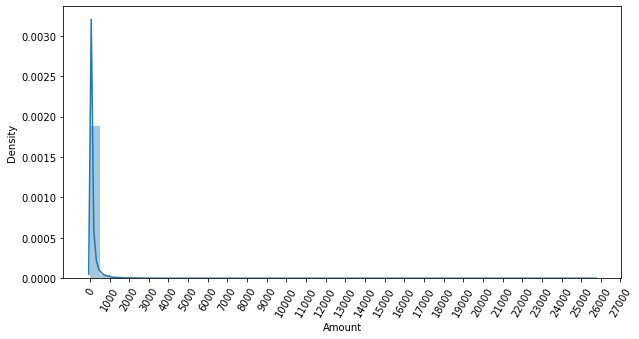

In [14]:
import seaborn as sns

plt.figure(figsize=(10,5))
plt.xticks(range(0,30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

## 데이터 사전 가공: StandardScaler을 이용해 정규분포 형태로 Amount 피쳐 변환

In [19]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1)) 
    # reshape()의 '-1'이 의미하는 바는, 변경된 배열의 '-1' 위치의 차원은 "원래 배열의 길이와 남은 차원으로 부터 추정"이 된다.
    # reshape[-1,3] 이면 무조건 열이 3인 값에 맞추어 행이 자동적으로 맞춰진다는 의미

    # 가공된 Amount_n을 Amount_sclaed 피쳐명으로 DataFrame 맨 앞 컬럼에 삽입
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # Time, Amount 피쳐 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

## StandardSclaer 변환 후 로지스틱 회귀 및 LightGBM 성능 평가

In [20]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("###로지스틱 회귀 예측 성능 평가###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, fit_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print("###LightGBM 예측 성능 평가###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, fit_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능 평가###
오차행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC: 0.9702
###LightGBM 예측 성능 평가###
오차행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC: 0.9779


로지스틱은 재현율이 조금 올랐으나 LightGBM은 오히려 하락

## Amount 로그 변환

In [21]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # Numpy 이용한 로그 변환
    amount_n = np.log1p(df_copy['Amount'])  # 1p = one plus
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # Time, Amount 피쳐 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

## Log 변환 후 로지스틱 회귀 및 LightGBM 성능 평가

In [22]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("###로지스틱 회귀 예측 성능 평가###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, fit_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print("###LightGBM 예측 성능 평가###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, fit_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능 평가###
오차행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC: 0.9727
###LightGBM 예측 성능 평가###
오차행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC: 0.9796


StandardSclaer보다 향상됨

# **데이터 2차 가공: 이상치 데이터 제거**

## 각 피쳐들의 상관관계 시각화

**결정 레이블 값과 가장 상관도가 높은 피쳐 추출**

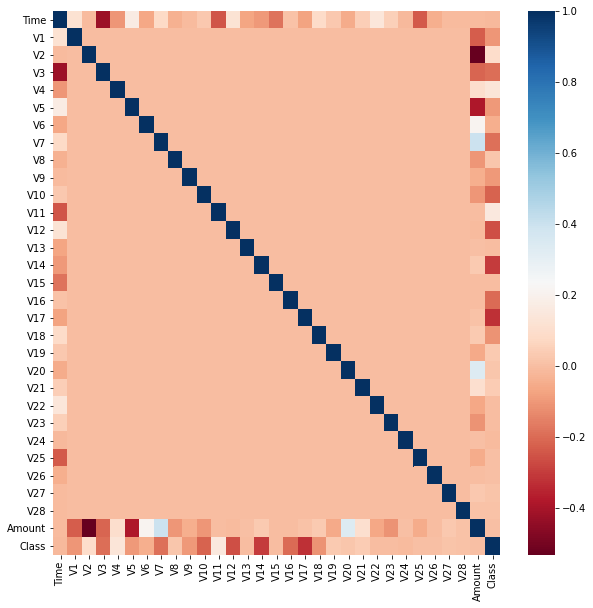

In [24]:
import seaborn as sns

plt.figure(figsize=(10,10))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

Class와 상관도가 높은 피쳐 V12,V14,V17<br/>
그 중 v14를 outlier를 통해 이상치를 제거해봄

## Outlier에 해당하는 데이터를 필터링하는 함수 생성

In [37]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 데이터만 추출
    fraud = df[df['Class']==1][column]
    # 1/4분위, 3/4분위 지점을 np.percentile로 구함
    quantile_25 = np.percentile(fraud.values,25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR 구함
    iqr = quantile_75 - quantile_25
    # IQR에 1.5를 곱하여 최대값, 최솟값 설정
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 아웃라이어 설정하고 DataFrame index로 반환
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [38]:
# 최고 부자
np.percentile(card_df['V14'].values, 100) # np.max(card_df) 와 동일

10.5267660517847

In [39]:
quantile_25 = np.percentile(card_df['V14'].values,25)
quantile_75 = np.percentile(card_df['V14'].values, 75)
print(quantile_25, quantile_75)

-0.4255740124549935 0.493149849218149


In [40]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print("이상치 인덱스: ", outlier_index)

이상치 인덱스:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


## 로그 변환 후 이상치 데이터 삭제한 모델 재학습/평가/예측

In [41]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # Numpy 이용한 로그 변환
    amount_n = np.log1p(df_copy['Amount'])  # 1p = one plus
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # Time, Amount 피쳐 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

In [42]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print("###로지스틱 회귀 예측 성능 평가###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, fit_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print("###LightGBM 예측 성능 평가###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, fit_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능 평가###
오차행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC: 0.9743
###LightGBM 예측 성능 평가###
오차행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC: 0.9780


# **데이터 3차 가공: SMOTE 오버 샘플링 적용**

In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 216)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print(f"SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트: {X_train.shape, y_train.shape}")
print(f"SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트: {X_train_over.shape, y_train_over.shape}")
print(f"SMOTE 적용 후 레이블 값 분포: \n{pd.Series(y_train_over).value_counts()}")

SMOTE 적용 전 학습용 피쳐/레이블 데이터 세트: ((199362, 29), (199362,))
SMOTE 적용 후 학습용 피쳐/레이블 데이터 세트: ((398040, 29), (398040,))
SMOTE 적용 후 레이블 값 분포: 
1    199020
0    199020
Name: Class, dtype: int64


## Logistic Regression 모델 적용

In [53]:
print("###로지스틱 회귀 예측 성능 평가###")
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, fit_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

###로지스틱 회귀 예측 성능 평가###
오차행렬
[[82930  2365]
 [   11   135]]
정확도: 0.9722, 정밀도: 0.0540, 재현율: 0.9247,    F1: 0.1020, AUC: 0.9735


RogisticRegression은 정밀도가 너무 낮다

## Rrecision-Recall 곡선 시각화

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold에 따른 정밀도, 재현율 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축 threshold, Y축 각각 정밀도, 재현율 값 (정밀도는 점선)
    plt.figure(figsize=(8,8))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label="Precision")
    plt.plot(thresholds, recalls[0:threshold_boundary], label="recall")
    
    # Threshold X축 Scale 0.1 단위 설정
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1), 2))
    
    # x축, y축 label, grid설정
    plt.xlabel('Threshold value'); plt.ylabel("Precision & Recall value")
    plt.legend()
    plt.grid()
    plt.show

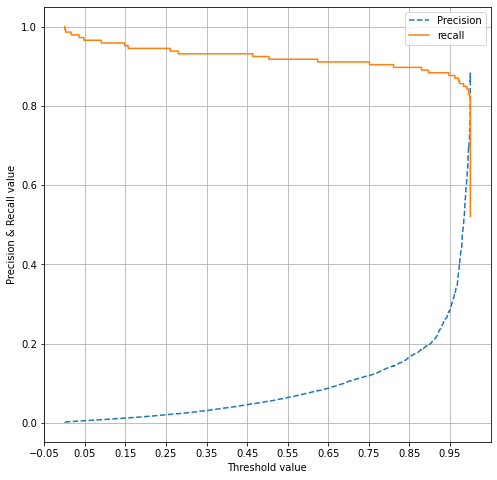

In [52]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

Rogistic Regression은 정밀도가 너무 낮아 부적합한 모델

## LightGBM 모델 적용

In [54]:
print("###LightGBM 예측 성능 평가###")
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, fit_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

###LightGBM 예측 성능 평가###
오차행렬
[[85285    10]
 [   26   120]]
정확도: 0.9996, 정밀도: 0.9231, 재현율: 0.8219,    F1: 0.8696, AUC: 0.9825
